# Portfolio Optimization: Kombinasi saham index LQ45 menurut Modern Portfolio Theorem By Markowitz dengan menggunakan Monte Carlo dan SciPy Optimizer
---
Model Optimisasi berikut diuji untuk mencari tau kombinasi saham index LQ45 manakah yang akan menghasilkan portfolio dengan return dan resiko yang optimal.
Data yang digunakan merupakan data historis dengan range selama 5 tahun dari sekarang.

Problem:
- Kombinasi mana yang menghasilkan portfolio dengan return dan resiko yang optimal ?
- Berapa bobot tiap saham dalam portfolio tersebut ?

---
Model and Anlysis by:\
    - **Ilham Willy Darmawan**\
    - <a href="https://www.linkedin.com/in/willy-darmawan/">**LinkedIn**</a>



## Import modul yang diperlukan

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Menentukan berapa lama periode historis

In [4]:
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

## Mengambil index LQ45 sebagai kombinasi pembuatan portfolio
index LQ45 digunakan dengan asumsi 45 saham teratas dengan liquiditas dan volume transaksi paling tinggi

In [5]:
data_index = pd.read_csv(r"./data2/index LQ45.csv")
stocks = data_index.dropna()["Kode"]

## Mengambil histori data bersumber dari yahoo finance

In [6]:
import yfinance as yf

data = {}
for stock in stocks:
    ticker = yf.Ticker(f"{stock}.JK")
    data[stock] = ticker.history(start=start_date, end=end_date)["Close"]

### Saving to csv, dan memotong saham yang memiliki data tidak lengkap

In [7]:
df = pd.DataFrame(data).dropna(axis = 1)
df.to_csv(r"./data2/data.csv")

### Checking Data

In [8]:
df.head()

,ACES,ADRO,AKRA,AMRT,ANTM,ARTO,ASII,BBCA,BBNI,BBRI,...,MDKA,MEDC,PGAS,PTBA,SIDO,SMGR,TLKM,TOWR,UNTR,UNVR
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-20 00:00:00+07:00,1544.858032,586.898926,613.312805,826.541992,905.199219,82.979202,4758.130859,5377.496094,3353.170166,3009.158691,...,1165.843384,581.163025,1390.673340,1071.337158,459.000458,11785.907227,3532.761230,618.463379,12717.829102,7582.769043
2019-08-21 00:00:00+07:00,1536.227539,575.719849,611.783447,831.238281,922.441162,103.568031,4702.588379,5368.511719,3277.453613,2972.461670,...,1190.233398,577.413574,1354.458008,1053.916992,464.961487,11563.110352,3485.341553,648.950989,12392.919922,7532.411133
2019-08-22 00:00:00+07:00,1536.227539,570.130371,620.960205,831.238281,896.578247,103.568031,4684.074219,5390.974609,3288.270508,2987.140381,...,1185.355469,573.664062,1307.377930,1053.916992,464.961487,11607.668945,3516.954346,631.529663,12361.976562,7603.749023
2019-08-23 00:00:00+07:00,1518.966675,606.462219,616.371887,817.149414,875.025940,103.568031,4869.215332,5386.482422,3299.086670,2994.479736,...,1214.623535,569.914734,1325.485718,1084.402222,476.883575,11652.229492,3461.631104,631.529663,12686.884766,7691.872559
2019-08-26 00:00:00+07:00,1562.119019,626.025452,625.548462,821.845703,887.957336,103.568031,4869.215332,5381.988770,3245.003418,2987.140381,...,1204.867432,547.418091,1387.051880,1049.561890,478.870667,11473.992188,3422.115479,618.463379,12454.808594,7700.266113


## Membuat Kombinasi n Saham dari data yang dimiliki
Dalam kasus ini, kita akan menggunakan 3 kombinasi dari total 45 saham yang ada di index LQ45\
\
Formula:
$$
  C_{(r,n)} = \frac{n!}{r! (n-r)!}
$$

In [9]:
from itertools import combinations

numOfStock = 3
portfolios = [stock for stock in combinations(df.columns, numOfStock)]


#### formula use:
- Stock Return:
$$
    R_{i, t} = log(\frac{P_{t}}{P_{t-1}})
$$
- Expected Stock Return:
$$
    E(R_{i}) = \frac {\sum \limits _{t=1} ^{n} R_{i, t}} {n} 
$$
- Expected Return Portfolio:
$$
    E(R_{p}) = W^{T} . E(R_{i})
$$
- Expected Volatility:
$$
    \sigma _{p} ^{2} = \sqrt {\sum \limits _{i=1} ^{n} \sum \limits _{j=1} ^{n} W_{i, t} . W_{i, j} . Cov(r_{i}, r_{j})}
$$
- Sharpe Ratio:
$$
    SR = \frac{E(R_{p})}{\sigma _{p} ^{2}}
$$

## MONTE CARLO SIMULATION WITH n=1000

In [ ]:
numOfSimulation     = 1000
weights             = np.zeros((numOfSimulation, numOfStock))
expected_return_p   = np.zeros(numOfSimulation)
expected_volatility = np.zeros(numOfSimulation)
sharpe_ratio        = np.zeros(numOfSimulation)

In [ ]:
result = {x: {} for x in range(len(portfolios))}
for i, portfolio in enumerate(portfolios):
    data = df.filter(items=portfolio) # type: ignore
    log_ret = np.log(data/data.shift(1))

    for j in range(numOfSimulation):
        w = np.array(np.random.random(numOfStock)) 
        w = w / np.sum(w)
        weights[j,:] = w
        
        expected_return_p[j] = np.sum(log_ret.mean() * w)*252
        expected_volatility[j] = np.sqrt(
            np.dot(
                    w.T, np.dot(
                        np.dot(
                            log_ret.cov(), 252), w) # type: ignore
                )
            )
        sharpe_ratio[j] = expected_return_p[j] / expected_volatility[j]
    
    maxIndex = sharpe_ratio.argmax()

    result[i]["portfolio"]              = portfolio
    result[i]["weight"]                 = weights[maxIndex,:].tolist()
    result[i]["expected_return"]        = expected_return_p[maxIndex]
    result[i]["expected_volatility"]    = expected_volatility[maxIndex]
    
    print(i, portfolio, weights[maxIndex,:])

## SCIPY OPTIMIZER TO CALCULATE WEIGHT

In [10]:
from scipy.optimize import minimize

def get_R_V_SR(w, eri, cov):
    w = np.array(w)
    R = np.sum(eri*w)
    V = np.sqrt(
        np.dot(
            w.T, np.dot(cov, w)
        )
    )

    sr = R/V

    return np.array([R, V, sr])



In [11]:
result = {x: {} for x in range(len(portfolios))}
constraints = ({"type":"eq", "fun": lambda x : np.sum(x)-1})

for i, portfolio in enumerate(portfolios):
    data = df.filter(items=portfolio) # type: ignore
    log_ret = np.log(data/data.shift(1))

    weight_optimized = minimize(
        lambda w: get_R_V_SR(w, log_ret.mean(), log_ret.cov())[-1]*-1,
        [1/numOfStock for _ in range(numOfStock)],
        method="SLSQP",
        bounds = tuple((0, 1) for _ in range(numOfStock)),
        constraints=constraints)
    
    result[i]["portfolio"]              = portfolio
    result[i]["weight"]                 = weight_optimized.x
    result[i]["expected_return"]        = np.sum(log_ret.mean() * weight_optimized.x)*252
    result[i]["expected_volatility"]    = np.sqrt(
            np.dot(
                    weight_optimized.x, np.dot(
                        np.dot(
                            log_ret.cov(), 252), weight_optimized.x) # type: ignore
                )
            )


## Portfolio Result

### Tidy up

In [12]:
result = pd.DataFrame(data=result).T
result["weight"] = result["weight"].apply(lambda i: list(map(lambda x: round(x*100, 2), i)))
result["expected_return"] = result["expected_return"].astype(float)
result["expected_volatility"] = result["expected_volatility"].astype(float)
result["sharpe_index"] = result["expected_return"].div(result["expected_volatility"])

In [13]:
result.head()

,portfolio,weight,expected_return,expected_volatility,sharpe_index
0,"(ACES, ADRO, AKRA)","[0.0, 74.55, 25.45]",0.314832,0.379826,0.828886
1,"(ACES, ADRO, AMRT)","[0.0, 52.59, 47.41]",0.310434,0.312347,0.993875
2,"(ACES, ADRO, ANTM)","[0.0, 100.0, 0.0]",0.358074,0.447648,0.799901
3,"(ACES, ADRO, ARTO)","[0.0, 62.36, 37.64]",0.497514,0.427702,1.163226
4,"(ACES, ADRO, ASII)","[0.0, 100.0, 0.0]",0.358074,0.447648,0.799901


### Plotting the result

<Axes: >

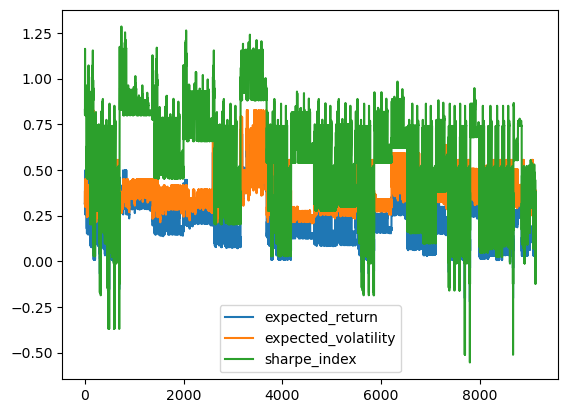

In [14]:
result.plot()

### Return Portfolio dan Resiko Portfolio memiliki korelasi positif
Artinya semakin tinggi return dari portfolio tersebut, semakin tinggi pula resiko yang dimiliki portfolio
\
Salah satu parameter portfolio yang optimal adalah **Sharpe Index**, dengan membagi return dengan resiko

In [15]:
import plotly_express as px

px.scatter(result, x=result["expected_volatility"], y=result["expected_return"], color=result["sharpe_index"], trendline="ols")

Data yang kita miliki, dapat diurutkan berdasarkan **sharpe index**, hingga didapatkanlah kombinasi portfolio dengan return dan resiko yang optimal

In [16]:
result.sort_values("sharpe_index", ascending=False)

,portfolio,weight,expected_return,expected_volatility,sharpe_index
740,"(ADRO, AMRT, ARTO)","[39.53, 35.75, 24.72]",0.413715,0.321808,1.285594
2052,"(AMRT, ARTO, ITMG)","[33.44, 25.95, 40.61]",0.401078,0.317363,1.263782
814,"(ADRO, ARTO, BRIS)","[45.66, 30.2, 24.14]",0.472399,0.376868,1.253485
3344,"(ARTO, BRIS, ITMG)","[30.84, 23.02, 46.15]",0.452458,0.364641,1.240831
820,"(ADRO, ARTO, HRUM)","[44.03, 31.97, 24.0]",0.473115,0.389825,1.213662
...,...,...,...,...,...
593,"(ACES, INTP, SMGR)","[100.0, 0.0, 0.0]",-0.154575,0.416837,-0.370828
7703,"(GGRM, INTP, UNVR)","[0.0, 100.0, 0.0]",-0.202567,0.395431,-0.512269
8677,"(INTP, SMGR, UNVR)","[100.0, 0.0, 0.0]",-0.202567,0.395431,-0.512269
7699,"(GGRM, INTP, SMGR)","[0.0, 100.0, 0.0]",-0.202567,0.395431,-0.512269


## Analisa Hasil

### Menganalisa 6 portfolio paling optimal
Dari hasil pengujian, didapatkan portfolio dengan kombinasi saham:\
ADRO: 39%\
AMRT: 36%\
ARTO: 25%\
dapat memberikan return tahunan sebesar 41%, dengan tingkat resiko 32%

---
Bila kita lihat, 6 potrfolio teratas merupakan kombinasi dari 6 saham\
ADRO, AMRT, ARTO, BRIS, HRUM, ITMG

In [17]:
optimal_portfolios = result.sort_values("sharpe_index", ascending=False)[:6]
optimal_portfolios

,portfolio,weight,expected_return,expected_volatility,sharpe_index
740,"(ADRO, AMRT, ARTO)","[39.53, 35.75, 24.72]",0.413715,0.321808,1.285594
2052,"(AMRT, ARTO, ITMG)","[33.44, 25.95, 40.61]",0.401078,0.317363,1.263782
814,"(ADRO, ARTO, BRIS)","[45.66, 30.2, 24.14]",0.472399,0.376868,1.253485
3344,"(ARTO, BRIS, ITMG)","[30.84, 23.02, 46.15]",0.452458,0.364641,1.240831
820,"(ADRO, ARTO, HRUM)","[44.03, 31.97, 24.0]",0.473115,0.389825,1.213662
3479,"(ARTO, HRUM, ITMG)","[31.75, 24.1, 44.15]",0.451064,0.372445,1.211087


In [18]:
stock_list = []
for p in optimal_portfolios["portfolio"].values:
    for s in p:
        stock_list.append(s)

Dari ke-6 saham ini, ARTO mempunyai frekuensi fluktuasi paling tinggi\
Tingkat perubahan harga ARTO menunjukkan bahwa, saham ini merupakan saham yang fluktuatif

In [19]:
portfolio1 = df.filter(items=list(set(stock_list)))

px.line(portfolio1.pct_change())

In [20]:
px.line(portfolio1 * 100 / portfolio1.iloc[0])

Covariance (Koefisien korelasi) dari ke 6 saham yang kita pilih menunjukkan beberapa saham terdistribusi dengan trend yang sama. kombinasi dari berbagai saham ini menghasilkan \
portfolio yang optimal.

array([[<Axes: xlabel='ITMG', ylabel='ITMG'>,
        <Axes: xlabel='AMRT', ylabel='ITMG'>,
        <Axes: xlabel='ADRO', ylabel='ITMG'>,
        <Axes: xlabel='BRIS', ylabel='ITMG'>,
        <Axes: xlabel='HRUM', ylabel='ITMG'>,
        <Axes: xlabel='ARTO', ylabel='ITMG'>],
       [<Axes: xlabel='ITMG', ylabel='AMRT'>,
        <Axes: xlabel='AMRT', ylabel='AMRT'>,
        <Axes: xlabel='ADRO', ylabel='AMRT'>,
        <Axes: xlabel='BRIS', ylabel='AMRT'>,
        <Axes: xlabel='HRUM', ylabel='AMRT'>,
        <Axes: xlabel='ARTO', ylabel='AMRT'>],
       [<Axes: xlabel='ITMG', ylabel='ADRO'>,
        <Axes: xlabel='AMRT', ylabel='ADRO'>,
        <Axes: xlabel='ADRO', ylabel='ADRO'>,
        <Axes: xlabel='BRIS', ylabel='ADRO'>,
        <Axes: xlabel='HRUM', ylabel='ADRO'>,
        <Axes: xlabel='ARTO', ylabel='ADRO'>],
       [<Axes: xlabel='ITMG', ylabel='BRIS'>,
        <Axes: xlabel='AMRT', ylabel='BRIS'>,
        <Axes: xlabel='ADRO', ylabel='BRIS'>,
        <Axes: xlabel='BRIS', y

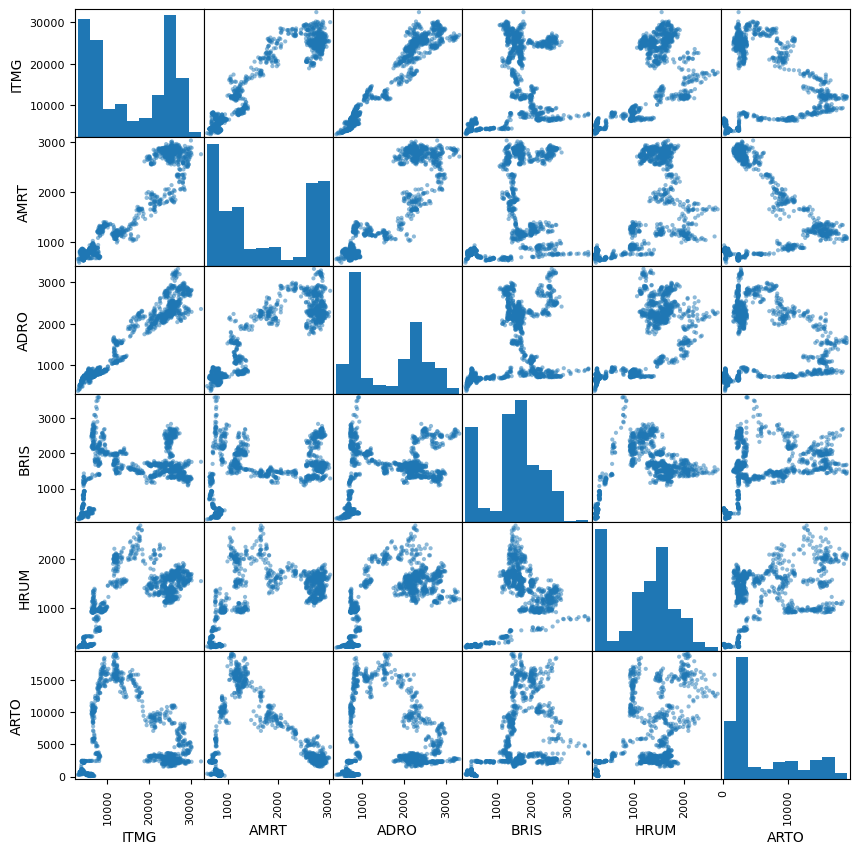

In [21]:
from pandas.plotting import scatter_matrix

scatter_matrix(portfolio1, figsize=(10,10))

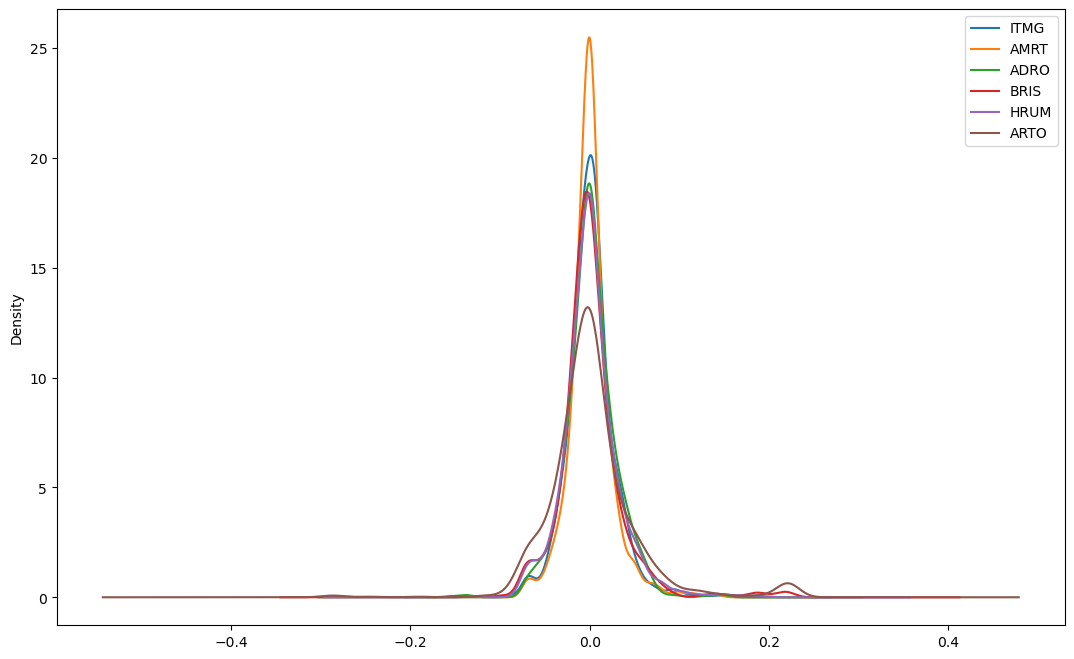

In [22]:
log_p = np.log(portfolio1/portfolio1.shift(1))
for stock in log_p:
    log_p[stock].plot(kind="kde", label=stock, figsize=(13,8))
plt.legend()

## Kesimpulan

In [98]:
from IPython.display import display, Markdown
display(Markdown("TOP 5 Portfolios combination from LQ45 with Optimal Return and Volatility"))

for i in range(5):
    display(Markdown(f"{i+1}. Kombinasi Saham **{optimal_portfolios[i:i+1]["portfolio"].to_string()[-18:]}**</br>\
        {optimal_portfolios[i:i+1]["portfolio"].to_list()[0][0]}: **{optimal_portfolios[i:i+1]["weight"].to_list()[0][0]}%**</br>\
        {optimal_portfolios[i:i+1]["portfolio"].to_list()[0][1]}: **{optimal_portfolios[i:i+1]["weight"].to_list()[0][1]}%**</br>\
        {optimal_portfolios[i:i+1]["portfolio"].to_list()[0][2]}: **{optimal_portfolios[i:i+1]["weight"].to_list()[0][2]}%**</br>\
        Expected Return per year: **{round(optimal_portfolios[i:i+1]["expected_return"].values[0]*100,2)}%**</br>\
        Expected Volatility per year: **{round(optimal_portfolios[i:i+1]["expected_volatility"].values[0]*100,2)}%**</br>\
        </br>"\
        ))

TOP 5 Portfolios combination from LQ45 with Optimal Return and Volatility

1. Kombinasi Saham **(ADRO, AMRT, ARTO)**</br>        ADRO: **39.53%**</br>        AMRT: **35.75%**</br>        ARTO: **24.72%**</br>        Expected Return per year: **41.37%**</br>        Expected Volatility per year: **32.18%**</br>        </br>

2. Kombinasi Saham **(AMRT, ARTO, ITMG)**</br>        AMRT: **33.44%**</br>        ARTO: **25.95%**</br>        ITMG: **40.61%**</br>        Expected Return per year: **40.11%**</br>        Expected Volatility per year: **31.74%**</br>        </br>

3. Kombinasi Saham **(ADRO, ARTO, BRIS)**</br>        ADRO: **45.66%**</br>        ARTO: **30.2%**</br>        BRIS: **24.14%**</br>        Expected Return per year: **47.24%**</br>        Expected Volatility per year: **37.69%**</br>        </br>

4. Kombinasi Saham **(ARTO, BRIS, ITMG)**</br>        ARTO: **30.84%**</br>        BRIS: **23.02%**</br>        ITMG: **46.15%**</br>        Expected Return per year: **45.25%**</br>        Expected Volatility per year: **36.46%**</br>        </br>

5. Kombinasi Saham **(ADRO, ARTO, HRUM)**</br>        ADRO: **44.03%**</br>        ARTO: **31.97%**</br>        HRUM: **24.0%**</br>        Expected Return per year: **47.31%**</br>        Expected Volatility per year: **38.98%**</br>        </br>

Keputusan Investasi kembali harus dipertimbangkan berdasarkan resiko yang dimiliki. Dengan optimisasi bobot serta kombinasi saham yang tepat, sebuah portfolio dapat memiliki tingkat pengembalian yang sesuai serta resiko yang minimum.